# CSCI 4050U - Final Project
## Forecasting (alleged) UFO Sightings by Location and Date
###### Group 1: Tomasz Puzio, Klein Cafa, Erica Patel


###Learning Problem
This machine learning model aims to predict the number of UFO sightings in Canadian provinces and American states during 2016.

This model covers a supervised regression problem, where the goal of the model is to estimate a numerical value (daily sighting count) based on historical patterns.

The neural network learns temporal patterns (i.e. the months that have more recorded sightings) and geographical patterns (i.e. states/provinces that historically reported more UFO activity).

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Install the necessary library
!pip install -q kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "UFOs_coord.csv"

# Load the dataset into a Pandas DataFrame
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "utkarshx27/ufo-sights-2016-us-and-canada",
  file_path,
  pandas_kwargs={"encoding": "latin1"}
)

/tmp/ipython-input-4093070345.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'ufo-sights-2016-us-and-canada' dataset.


In [ ]:
print("--- DataFrame Information ---")
print(df.info())
print("\nFirst 5 records:")
print(df.head())

--- DataFrame Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date / Time  5177 non-null   object 
 1   Country      5177 non-null   object 
 2   City         5177 non-null   object 
 3   State        5177 non-null   object 
 4   Shape        5177 non-null   object 
 5   Summary      5177 non-null   object 
 6   lat          5177 non-null   float64
 7   lng          5177 non-null   float64
dtypes: float64(2), object(6)
memory usage: 323.7+ KB
None

First 5 records:
      Date / Time Country        City State    Shape  \
0  12/21/16 19:15     USA  Waynesboro    VA   Sphere   
1  12/21/16 00:00     USA  Louisville    KY  Unknown   
2  12/20/16 22:30     USA  Santa Rosa    CA   Sphere   
3  12/20/16 19:00     USA      Fresno    CA   Circle   
4  12/19/16 21:53     USA     Reymert    AZ   Circle   

                              

###Data Cleaning

In [ ]:
# Convert Date / Time column into a proper datetime object
df['Date / Time'] = pd.to_datetime(df['Date / Time'], errors='coerce')

/tmp/ipython-input-2548338211.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date / Time'] = pd.to_datetime(df['Date / Time'], errors='coerce')


In [ ]:
# Check if any rows failed to parse
df[df['Date / Time'].isna()]

,Date / Time,Country,City,State,Shape,Summary,lat,lng
65,NaT,USA,Hagerstown,MD,Fireball,Green fire aux.,39.641922,-77.720264
66,NaT,USA,Jacksonville,FL,Light,"Looking in the east night sky, two airplanes w...",30.332184,-81.655651
67,NaT,USA,Taos,NM,Light,"Large light, equivalent to car lights 1 mile a...",36.407249,-105.573066
68,NaT,USA,Stevens Pass,WA,Changing,"Shifting orb witnessed at Stevens Pass, WA. ((...",47.745635,-121.089172
69,NaT,USA,Marietta,GA,Light,The light remained in same location for at lea...,33.952847,-84.549615
...,...,...,...,...,...,...,...,...
5172,NaT,USA,Elk Grove,CA,Light,6-7 peach-colored craft moving easterly direct...,38.408799,-121.371618
5173,NaT,USA,Anchorage,AK,Circle,New Years yellow objects.,61.216313,-149.894852
5174,NaT,USA,Sodaville,OR,Sphere,Two balls of orange light seen above the trees...,44.483395,-122.869982
5175,NaT,USA,Arnold,MO,Triangle,Triangle obj. moving W to SE from my position....,38.432832,-90.377619


In [ ]:
# If there's many rows that are 'bad', drop them
df = df.dropna(subset=['Date / Time'])

In [ ]:
# Extract key features from the date column
df['year'] = df['Date / Time'].dt.year
df['month'] = df['Date / Time'].dt.month
df['day'] = df['Date / Time'].dt.day
df['weekday'] = df['Date / Time'].dt.weekday
df['hour'] = df['Date / Time'].dt.hour

df['day_of_year'] = df['Date / Time'].dt.dayofyear
df['week_of_year'] = df['Date / Time'].dt.isocalendar().week

In [ ]:
# Group dataset by state for enough detail & samples
# Gives us | State | year | month | day | count
# count = # of UFO sightings on that day in the state (target we are predicting)
df_grouped = df.groupby(['State', 'year', 'month', 'day', 'day_of_year', 'week_of_year']).size().reset_index(name='count')

In [ ]:
# Since text like "FL" or "CA" can't be fed into the model, one-hot encoding is
# used to create columns State_FL, State_CA, etc.
df_encoded = pd.get_dummies(df_grouped, columns=['State'])

In [ ]:
# Build Matrix X and Target y
feature_cols = ['year', 'month', 'day', 'day_of_year', 'week_of_year'] + [col for col in df_encoded.columns if col.startswith('State_')]

X = df_encoded[feature_cols].values
y = df_encoded['count'].values

In [ ]:
# Normalize X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train/Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((1748, 64), (438, 64))

##EDA (Exploration)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

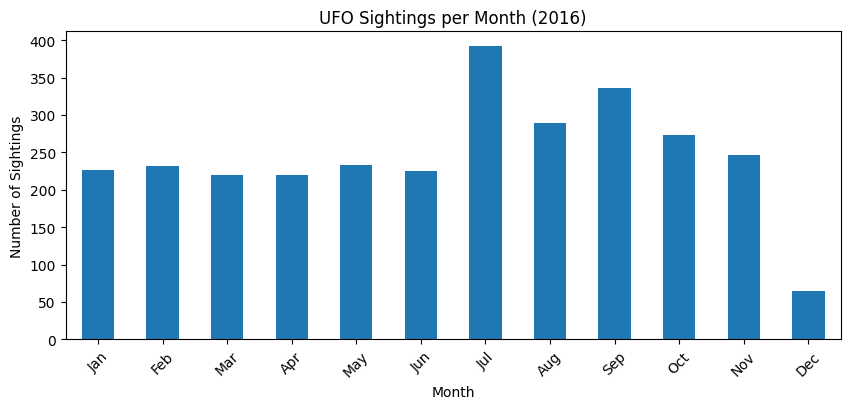

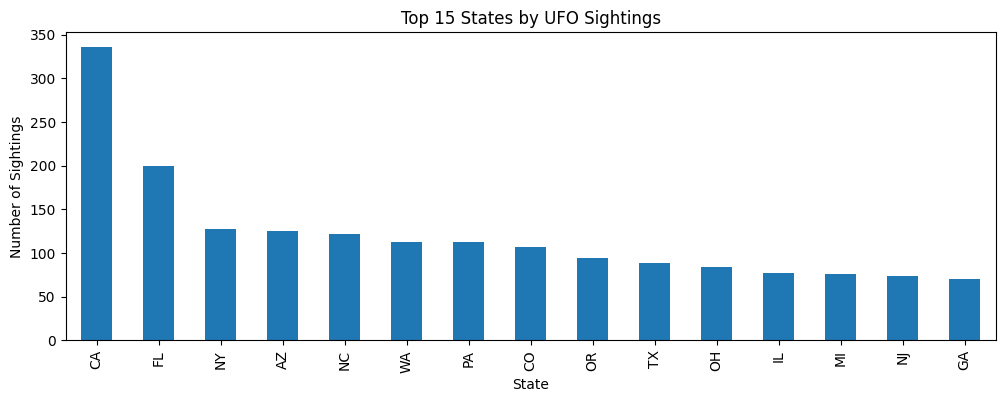

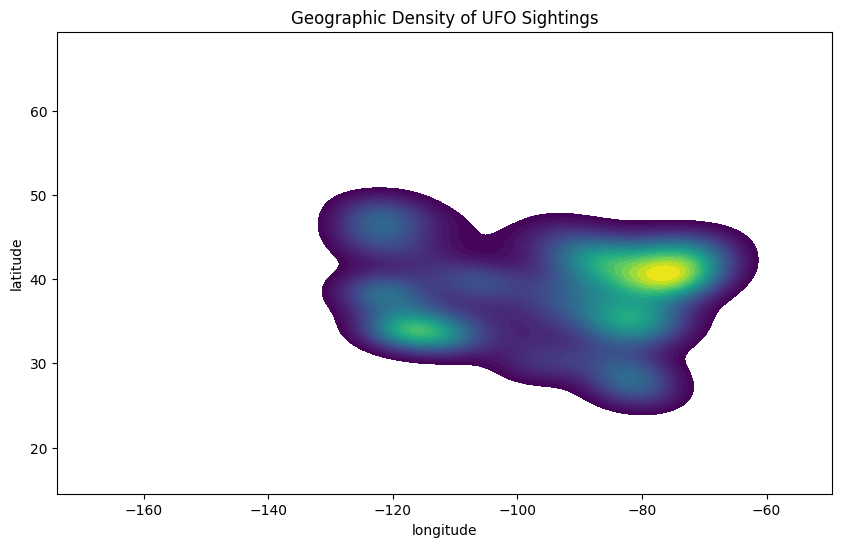

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,4))
df.groupby('month').size().plot(kind='bar')
plt.title("UFO Sightings per Month (2016)")
plt.xlabel("Month")
plt.xticks(ticks=range(0,12), labels=[
    "Jan","Feb","Mar","Apr","May","Jun",
    "Jul","Aug","Sep","Oct","Nov","Dec"
], rotation=45)
plt.ylabel("Number of Sightings")
plt.show()

plt.figure(figsize=(12,4))
df['State'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 States by UFO Sightings")
plt.xlabel("State")
plt.ylabel("Number of Sightings")
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(x=df['lng'], y=df['lat'], fill=True, cmap="viridis", levels=50)
plt.title("Geographic Density of UFO Sightings")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

##Linear Regression Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

=== Linear Regression Performance ===
Train MSE: 1.9881
Test  MSE:  0.5814
Train MAE: 0.4937
Test  MAE:  0.5066


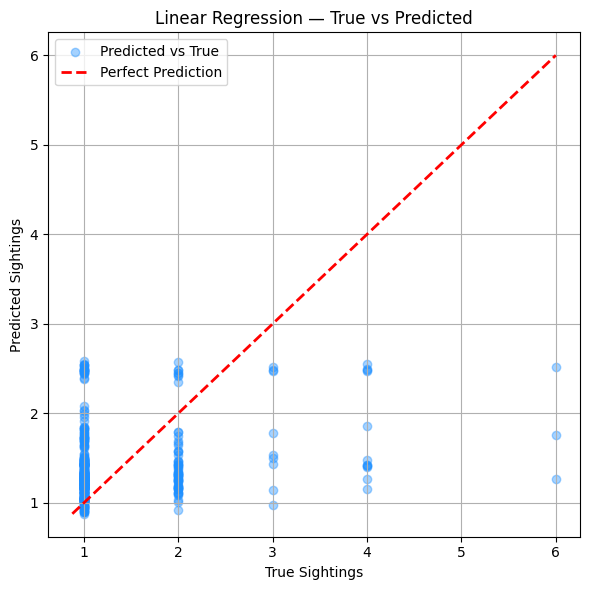

In [ ]:
# Linear Regression Baseline Model

# Train Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("=== Linear Regression Performance ===")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test  MSE:  {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test  MAE:  {test_mae:.4f}")

# Plot true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.4, color='dodgerblue', label='Predicted vs True')
max_val = max(max(y_test), max(y_pred_test))
min_val = min(min(y_test), min(y_pred_test))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel("True Sightings")
plt.ylabel("Predicted Sightings")
plt.title("Linear Regression — True vs Predicted")
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Baseline Model: Mean Predictor
y_baseline = np.full_like(y_test, y_train.mean())
baseline_mse = mean_squared_error(y_test, y_baseline)
baseline_mae = mean_absolute_error(y_test, y_baseline)

print("\n=== Baseline Mean Predictor ===")
print(f"Baseline MSE: {baseline_mse:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")


=== Baseline Mean Predictor ===
Baseline MSE: 0.6507
Baseline MAE: 0.3082


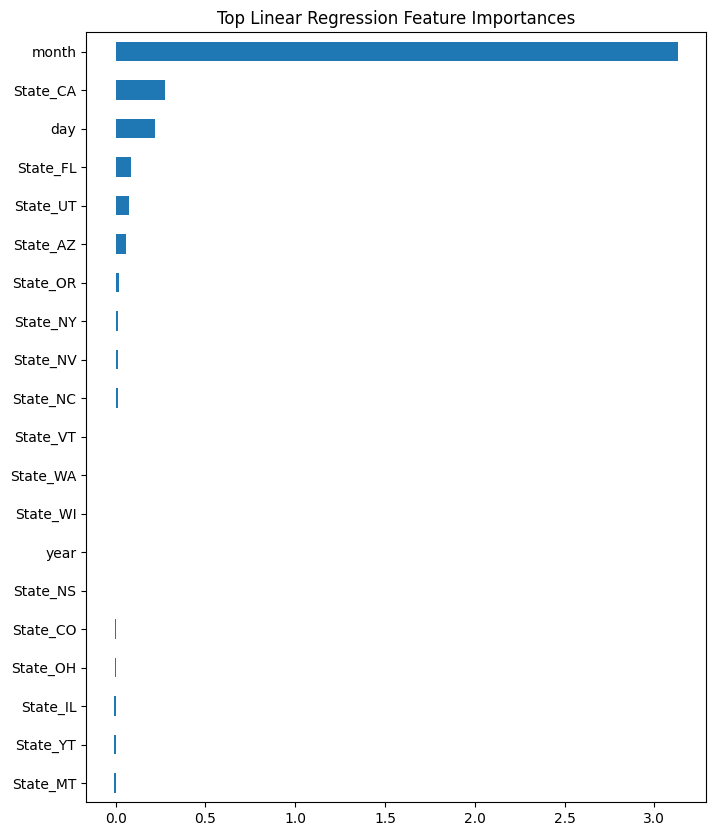

In [ ]:
# Linear Regression Feature Importance
importance = pd.Series(linreg.coef_, index=feature_cols)
importance.sort_values(ascending=False).head(15)
# Plot Feature Importance
importance.sort_values().tail(20).plot(kind='barh', figsize=(8,10))
plt.title("Top Linear Regression Feature Importances")
plt.show()

## MLP (Multi Layer Preceptron)

### Constructing PyTorch DataLoader

In [ ]:
!pip install -q torchinfo

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import Adam
from torch.nn.functional import mse_loss, l1_loss # l1_loss is MAE
from torchinfo import summary
import matplotlib.pyplot as plt

In [ ]:
def create_pytorch_datasets(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    # Target (y) must be float32 for regression.
    # unsqueeze(1) converts (N,) to (N, 1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    return train_dataset, test_dataset

In [ ]:
def make_dataloader(dataset: Dataset, batch_size:int, shuffle:bool) -> DataLoader:
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [ ]:
train_dataset, test_dataset = create_pytorch_datasets(X_train, y_train, X_test, y_test)
batch_size = 64
train_dataloader = make_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = make_dataloader(test_dataset, batch_size=batch_size, shuffle=False)

### MLP with hidden layer

In [ ]:
# Add output activation to prevent negative predictions
class MLPRegression(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        hidden_size = 100
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
        self.output_act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.act1(x)
        logits = self.output(x)
        return self.output_act(logits)

# Instantiate the model before defining the optimizer
input_size = X_train.shape[1]
mlp_reg = MLPRegression(input_size=input_size)
optimizer = Adam(mlp_reg.parameters(), lr=0.0001)

In [ ]:
input_size = X_train.shape[1]
m = MLPRegression(input_size=input_size)
print(summary(m, input_size=(32, input_size)))

Layer (type:depth-idx)                   Output Shape              Param #
MLPRegression                            [32, 1]                   --
├─Linear: 1-1                            [32, 100]                 6,500
├─ReLU: 1-2                              [32, 100]                 --
├─Linear: 1-3                            [32, 1]                   101
├─ReLU: 1-4                              [32, 1]                   --
Total params: 6,601
Trainable params: 6,601
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.21
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.03
Estimated Total Size (MB): 0.06


### Training Loop

In [ ]:
def train_regression(model: nn.Module, optimizer: torch.optim.Optimizer, train_loader: DataLoader, test_loader: DataLoader, epochs: int):
    history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_mae = 0

        # Training loop
        for (x, target) in train_loader:
            # Forward pass
            prediction = model(x)

            # Calculate MSE loss
            loss = mse_loss(prediction, target)

            # Backpropagation and Optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Accumulate metrics
            train_loss += loss.item()
            train_mae += l1_loss(prediction, target).item()

        # Average training metrics
        train_loss /= len(train_loader)
        train_mae /= len(train_loader)

        # Validation evaluation
        model.eval()
        val_loss = 0
        val_mae = 0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                pred = model(x_val)
                val_loss += mse_loss(pred, y_val).item()
                val_mae += l1_loss(pred, y_val).item()

        val_loss /= len(test_loader)
        val_mae /= len(test_loader)

        metrics = {
            'epoch': epoch,
            'train_loss': train_loss,
            'train_mae': train_mae,
            'val_loss': val_loss,
            'val_mae': val_mae
        }

        if epoch % (epochs // 10) == 0:
            print(f"{epoch}: train_loss={train_loss:.4f}, train_mae={train_mae:.4f}, val_loss={val_loss:.4f}, val_mae={val_mae:.4f}")

        history.append(metrics)

    return pd.DataFrame(history)

0: train_loss=2.8608, train_mae=0.8125, val_loss=0.7996, val_mae=0.5214
10: train_loss=1.9415, train_mae=0.4849, val_loss=0.5837, val_mae=0.4974
20: train_loss=1.9232, train_mae=0.5155, val_loss=0.6566, val_mae=0.5144
30: train_loss=1.9067, train_mae=0.4933, val_loss=0.6027, val_mae=0.4901
40: train_loss=1.8821, train_mae=0.4734, val_loss=0.6141, val_mae=0.4971
50: train_loss=1.8711, train_mae=0.4717, val_loss=0.6370, val_mae=0.5225
60: train_loss=1.8516, train_mae=0.4623, val_loss=0.6614, val_mae=0.5443
70: train_loss=1.9163, train_mae=0.4651, val_loss=0.6885, val_mae=0.5677
80: train_loss=1.8339, train_mae=0.4615, val_loss=0.6765, val_mae=0.5241
90: train_loss=1.8169, train_mae=0.4570, val_loss=0.7022, val_mae=0.5614

--- Training Complete ---
Final training loss (MSE): 1.8247
Final training MAE: 0.4532
Final validation loss (MSE): 0.6967
Final validation MAE: 0.5552


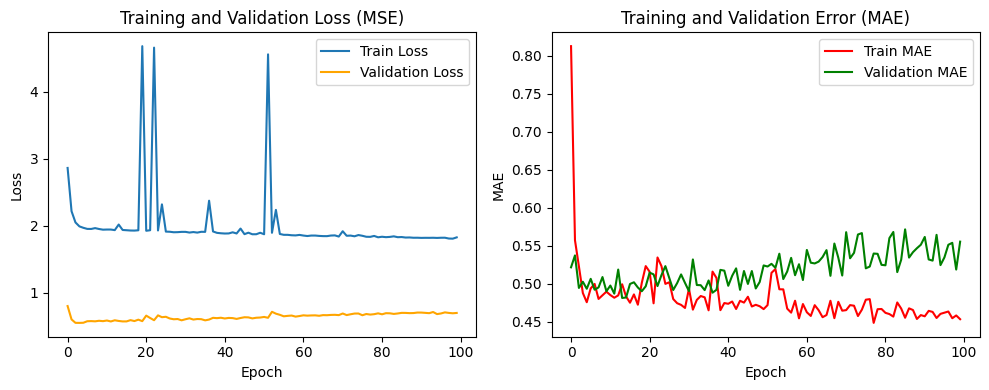

In [ ]:
# Re-instantiate the model and optimizer
mlp_reg = MLPRegression(input_size=X_train.shape[1])
optimizer = Adam(mlp_reg.parameters(), lr=0.001)

# Run training loop
epochs = 100
history_mlp_reg = train_regression(mlp_reg, optimizer, train_dataloader, test_dataloader, epochs=epochs)

print("\n--- Training Complete ---")

print(f"Final training loss (MSE): {history_mlp_reg['train_loss'].iloc[-1]:.4f}")
print(f"Final training MAE: {history_mlp_reg['train_mae'].iloc[-1]:.4f}")
print(f"Final validation loss (MSE): {history_mlp_reg['val_loss'].iloc[-1]:.4f}")
print(f"Final validation MAE: {history_mlp_reg['val_mae'].iloc[-1]:.4f}")

# Plot the loss and MAE
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

# MSE Loss plot
history_mlp_reg['train_loss'].plot.line(ax=axes[0], label='Train Loss')
history_mlp_reg['val_loss'].plot.line(ax=axes[0], label='Validation Loss', color='orange')
axes[0].set_title("Training and Validation Loss (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Mean Absolute Error (MAE) plot
history_mlp_reg['train_mae'].plot.line(ax=axes[1], color='red', label='Train MAE')
history_mlp_reg['val_mae'].plot.line(ax=axes[1], color='green', label='Validation MAE')
axes[1].set_title("Training and Validation Error (MAE)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")
axes[1].legend()

plt.tight_layout()
plt.show()

### Deployment

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime

# Extract unique states & provinces from the dataframe
unique_states = sorted(df['State'].unique().tolist())

# Create interactive widget
state_dropdown = widgets.Dropdown(
    options=unique_states,
    description='State:',
    value=unique_states[0]
)

date_picker = widgets.DatePicker(
    description='Date:',
    value=datetime(2016, 6, 15)
)

predict_button = widgets.Button(
    description='Predict Sightings',
    button_style='success',
)

output = widgets.Output()

def predict_sightings(b):
    with output:
        output.clear_output()

        # Extract features
        selected_date = date_picker.value
        selected_state = state_dropdown.value

        month = selected_date.month
        day = selected_date.day
        day_of_year = selected_date.timetuple().tm_yday
        week_of_year = selected_date.isocalendar()[1]

        features = np.zeros(X_train.shape[1])

        features[0] = 2016
        features[1] = month
        features[2] = day
        features[3] = day_of_year
        features[4] = week_of_year

        # One-hot encode state
        # Get column name for the selected state
        state_col = f'State_{selected_state}'

        # Find which index the state corresponds to
        if state_col in df_encoded.columns:
            # Get all state columns in the same order as training
            state_cols = [col for col in df_encoded.columns if col.startswith('State_')]
            state_idx = state_cols.index(state_col)
            features[5 + state_idx] = 1  # Set the one-hot encoding

        # Normalize using the same scaler from training
        features_scaled = scaler.transform(features.reshape(1, -1))

        # Predict
        mlp_reg.eval()
        with torch.no_grad():
            prediction = mlp_reg(torch.FloatTensor(features_scaled))

        print(f"📅 Date: {selected_date.strftime('%B %d, 2016')}")
        print(f"📍 State/Province: {selected_state}")
        print(f"🛸 Predicted Sightings: {prediction.item():.2f}")
        print(f"\n⚠️ Model Confidence: LOW (MAE ≈ 0.56)")
        print(f"💡 Model predicts ~{int(round(prediction.item()))} sighting(s)")

predict_button.on_click(predict_sightings)

# Display interface
display(widgets.VBox([
    widgets.HTML("<h2>🛸 UFO Sighting Predictor</h2>"),
    widgets.HTML(f"<p>Available states/provinces: {len(unique_states)}</p>"),
    state_dropdown,
    date_picker,
    predict_button,
    output
]))

In [ ]:
# Check the distribution of actual sightings
print("Distribution of actual UFO counts:")
print(df_grouped['count'].value_counts().sort_index().head(20))
print(f"\nMean sightings per day per state: {df_grouped['count'].mean():.2f}")
print(f"Median: {df_grouped['count'].median():.0f}")
print(f"Max: {df_grouped['count'].max()}")

# Check what percentage are 0 or 1
low_counts = (df_grouped['count'] <= 1).sum()
print(f"\nDays with 0-1 sightings: {low_counts}/{len(df_grouped)} ({100*low_counts/len(df_grouped):.1f}%)")

Distribution of actual UFO counts:
count
1     1693
2      363
3       81
4       29
5        6
6        9
7        1
9        1
10       1
20       1
50       1
Name: count, dtype: int64

Mean sightings per day per state: 1.35
Median: 1
Max: 50

Days with 0-1 sightings: 1693/2186 (77.4%)


##Model Comparison


--- Model Comparison ---
Linear Regression Test MAE: 0.5066
MLP Test MAE:              0.5552

Linear Regression Test MSE: 0.5814
MLP Test MSE:               0.6967



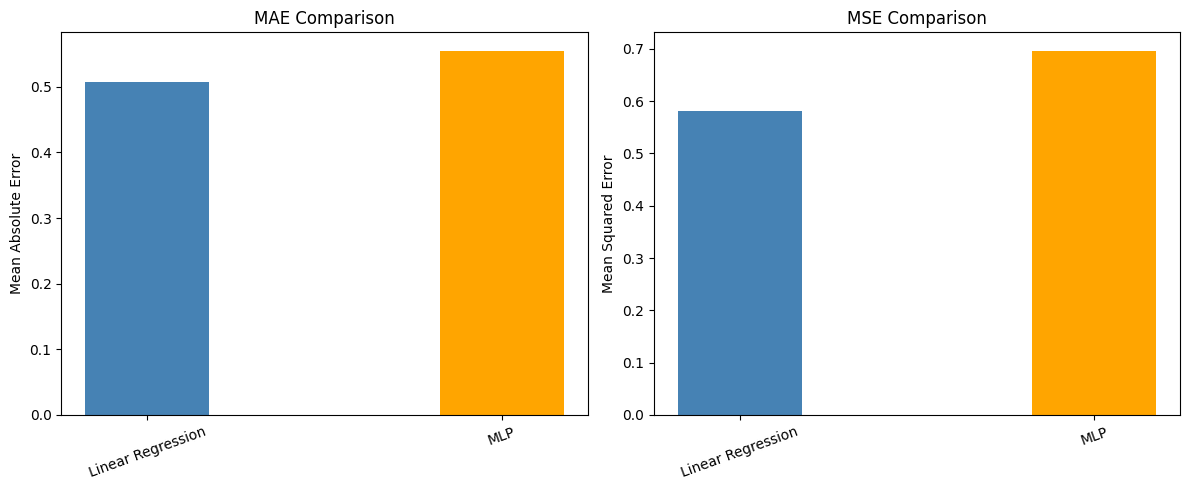

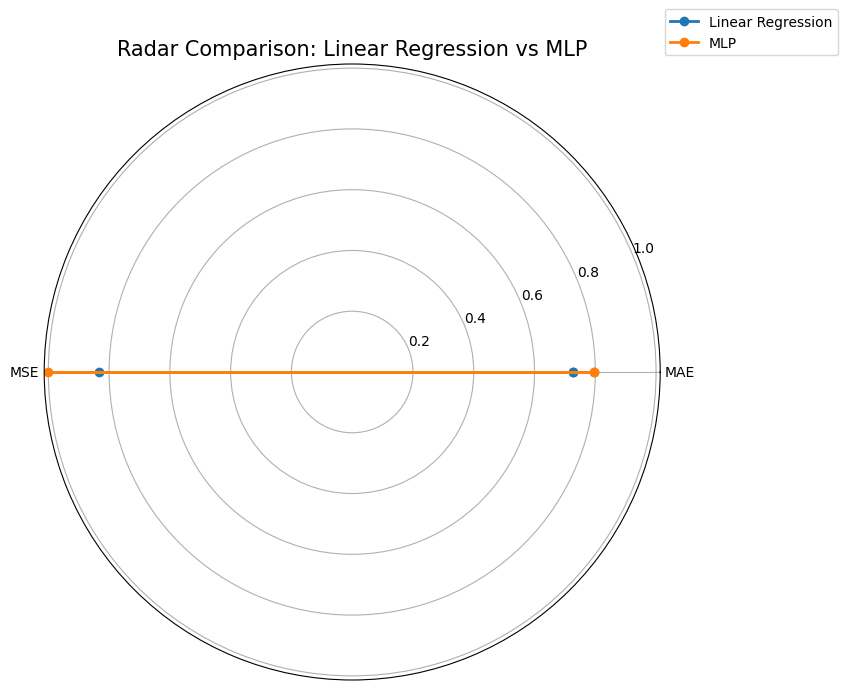

In [ ]:
# Model Comparison: Linear Regression vs MLP

# Extract final MLP metrics
mlp_test_mae = history_mlp_reg['val_mae'].iloc[-1]
mlp_test_mse = history_mlp_reg['val_loss'].iloc[-1]

print("\n--- Model Comparison ---")
print(f"Linear Regression Test MAE: {test_mae:.4f}")
print(f"MLP Test MAE:              {mlp_test_mae:.4f}")

print(f"\nLinear Regression Test MSE: {test_mse:.4f}")
print(f"MLP Test MSE:               {mlp_test_mse:.4f}\n")

# --- Visualization: Bar Chart Comparison ---

import matplotlib.pyplot as plt
import numpy as np

models = ['Linear Regression', 'MLP']
mae_values = [test_mae, mlp_test_mae]
mse_values = [test_mse, mlp_test_mse]

x = np.arange(len(models))  # [0,1]
width = 0.35  # Bar width

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# MAE Plot
ax[0].bar(x, mae_values, width, color=['steelblue', 'orange'])
ax[0].set_title("MAE Comparison")
ax[0].set_ylabel("Mean Absolute Error")
ax[0].set_xticks(x)
ax[0].set_xticklabels(models, rotation=20)

# MSE Plot
ax[1].bar(x, mse_values, width, color=['steelblue', 'orange'])
ax[1].set_title("MSE Comparison")
ax[1].set_ylabel("Mean Squared Error")
ax[1].set_xticks(x)
ax[1].set_xticklabels(models, rotation=20)

plt.tight_layout()
plt.show()

# Radar Chart: Linear Regression vs MLP

# Final MLP metrics
metrics = ['MAE', 'MSE']

# Normalized values (lower = better)
linreg_vals = np.array([test_mae, test_mse])
mlp_vals = np.array([mlp_test_mae, mlp_test_mse])

# Normalize for radar plot
all_vals = np.concatenate([linreg_vals, mlp_vals])
max_val = all_vals.max()
linreg_plot = linreg_vals / max_val
mlp_plot = mlp_vals / max_val

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
linreg_plot = np.concatenate((linreg_plot, [linreg_plot[0]]))
mlp_plot = np.concatenate((mlp_plot, [mlp_plot[0]]))
angles = np.concatenate((angles, [angles[0]]))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

ax.plot(angles, linreg_plot, 'o-', linewidth=2, label='Linear Regression')
ax.fill(angles, linreg_plot, alpha=0.2)

ax.plot(angles, mlp_plot, 'o-', linewidth=2, label='MLP')
ax.fill(angles, mlp_plot, alpha=0.2)

ax.set_thetagrids(angles[:-1] * 180/np.pi, metrics)
ax.set_title("Radar Comparison: Linear Regression vs MLP", fontsize=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

##Conclusion
- The supervised regression model is used to forecast UFO daily sighting counts in Canada and the U.S. during 2016
- A structured dataset prepared  extensive data cleaning and feature engineering
- UFO sightings are seen as uneven, where 77% of days have 0-1 sightings, which can make predictions challenging
- Summer months show higher activity
- New York, California and Florida show higher activity
- Classic models can outperform neural networks when data is limited
- Linear Regression has the best overall performance
- Scaling, encoding and grouping is important for accurate predictions
- Overall, the models had the ability to catch basic temporary and geographic patterns in UFO reports. Linear Regression shows best performance to provide simplicity, balance and predictive accuracy.
